<a href="https://colab.research.google.com/github/GulnazaS/Fake-or-real-news/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%84%D0%B0%D0%BB%D1%8C%D1%88%D0%B8%D0%B2%D1%8B%D1%85_%D0%BD%D0%BE%D0%B2%D0%BE%D1%81%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек и загрузка датасета

In [351]:
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn. metrics import precision_recall_curve
import sklearn.metrics as sk_metrics
from sklearn. metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV

In [353]:
!pip install pymorphy2

In [354]:
from nltk.corpus import stopwords #импорт набора стоп-слов
import pymorphy2
import re #регулярные выражения
from string import punctuation
import re
import nltk

In [355]:
import warnings

# Отключение предупреждений
warnings.filterwarnings('ignore')

In [356]:
categories = ["fake", "real"]
labels = [0, 1]
df = pd.read_csv('/content/fake_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [357]:
nltk.download('stopwords')
stopWords = stopwords.words("english")
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [358]:
def lemmatize(content):
    review = re.sub('(?i)[^A-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [morph.parse(word)[0].normal_form for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

## Исследование датасета

In [359]:
#Размерность массива
df.shape

(6335, 4)

In [360]:
#Заголовки массива
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [361]:
#Общая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [362]:
# Поиск нулевых значений
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [363]:
df['title_normalize'] = df['title'].apply(lemmatize)

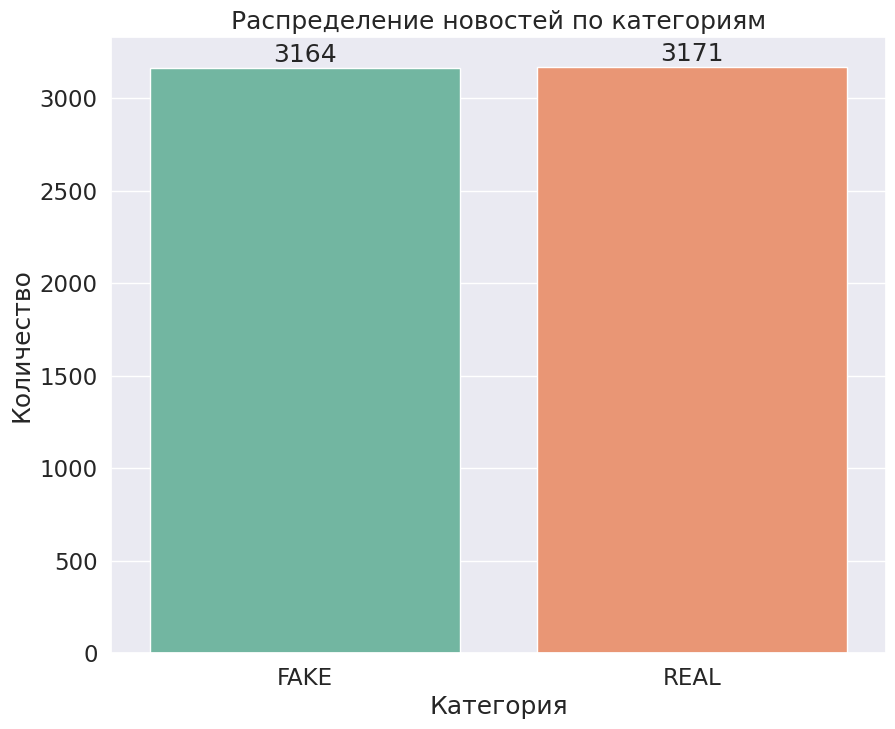

In [364]:
plt.figure(figsize=(10,8))
sns.countplot(x=df['label'], palette='Set2')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.title("Распределение новостей по категориям")

#Добавление значений к каждому столбцу
ax = plt.gca()  # Получение текущей оси графика
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.0f'),
  (p.get_x() + p.get_width() / 2., p.get_height()),
  ha='center', va='center',
  xytext=(0, 9),
  textcoords='offset points')

plt.show()

In [365]:
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

## Обучение модели

In [366]:
#Приведение значений к int
df['label'] = np.where(df['label']=='REAL', 1, 0)

In [367]:
x_train,x_test,y_train,y_test=train_test_split(df['title_normalize'],
                                               df['label'],
                                               test_size=0.2,
                                               random_state=7)

In [368]:
print('Тренировочный набор:', x_train.shape)
print('Тестовой набор:', x_test.shape)

Тренировочный набор: (5068,)
Тестовой набор: (1267,)


In [369]:
tfidf = TfidfVectorizer(stop_words=stopWords, max_df=0.7)
train = tfidf.fit_transform(x_train)
test = tfidf.transform(x_test)

In [370]:
# Определение параметров для GridSearchCV
parameters = {'max_iter': [1, 5], 'C': [0.001, 0.01, 0.1, 1, 10]}

# Создание экземпляра модели PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier()

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(pac, parameters, cv=5)
grid_search.fit(train, y_train)

# Получение лучших параметров
best_params = grid_search.best_params_

# Обучение модели с лучшими параметрами
pac_best = PassiveAggressiveClassifier(max_iter=best_params['max_iter'], C=best_params['C'])
pac_best.fit(train, y_train)

# Предсказание на тестовой выборке
y_pred = pac_best.predict(test)

# Оценка точности модели
score_pac = accuracy_score(y_test, y_pred)
print(f'Точность на тестовой выборке с оптимальными параметрами: {round(score_pac*100, 2)}%')

Точность на тестовой выборке с оптимальными параметрами: 82.56%


## Оценка производительности

In [371]:
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[545  93]
 [128 501]]


Text(0.5, 11.049999999999999, 'Предсказанный вид новостей')

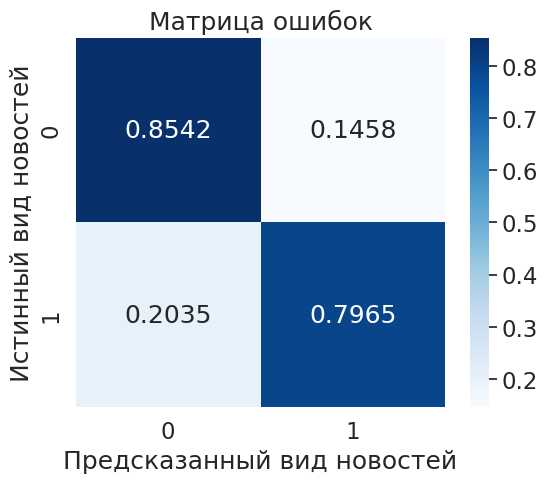

In [387]:
confusion = confusion_matrix(y_test, y_pred,labels=[0,1])
confusion_normalized = confusion/confusion.sum(axis=1, keepdims=True)
axis_labels = range(2)
ax = sns.heatmap(
                confusion_normalized,
                xticklabels=axis_labels,
                yticklabels=axis_labels,
                cmap='Blues',
                annot=True,
                fmt='.4f',
                square=True
                )
plt.title("Матрица ошибок")
plt.ylabel("Истинный вид новостей")
plt.xlabel("Предсказанный вид новостей")

## Логистическая регрессия

In [373]:
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(train,y_train)

LogisticRegression()

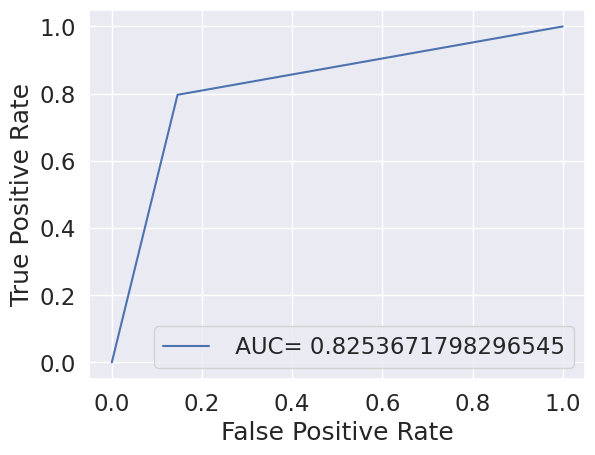

In [374]:
y_pred_proba = log_regression. predict_proba (test)[::,1]
fpr, tpr, _ = metrics. roc_curve (y_test, y_pred)
auc = metrics. roc_auc_score (y_test, y_pred)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [375]:
import matplotlib.pyplot as plt
y_score = log_regression.predict_proba(test)[:, 1 ]

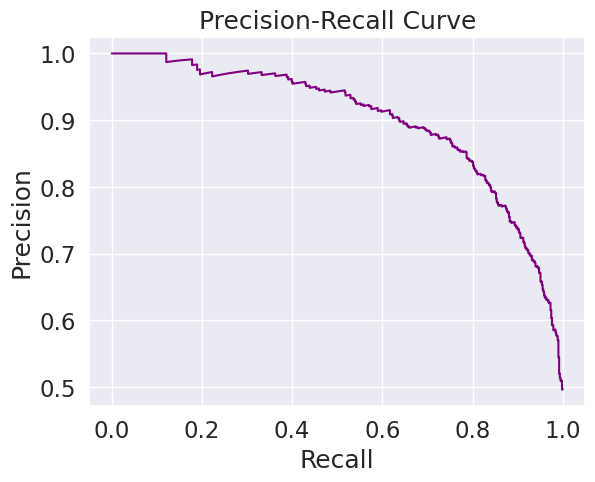

In [376]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

## Расчет MSE, RMSE и средней абсолютной ошибки

In [385]:
def mse(y_test, y_pred):
 actual, pred = np.array(y_test), np.array(y_pred)
 return np.square(np.subtract(y_test,y_pred)).mean()

def rmse(y_test, y_pred):
  actual, pred = np.array(y_test), np.array(y_pred)
  return np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())

In [386]:
print(f'Среднеквадратическая ошибка (MSE): {mse(y_test, y_pred)}')
print(f'Корень среднеквадратической ошибки (RMSE): {rmse(y_test, y_pred)}')
print(f'Средняя абсолютная ошибка: {mae(y_test, y_pred)}')

Среднеквадратическая ошибка (MSE): 0.17442778216258878
Корень среднеквадратической ошибки (RMSE): 0.41764552213879746
Средняя абсолютная ошибка: 0.17442778216258878
